In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install ultralytics pycocotools > install.txt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import yaml
import torch
import shutil
from ultralytics import YOLO
from tqdm import tqdm

In [4]:
pwd

'/kaggle/working'

In [5]:
train_imgs_dir="/kaggle/input/car-object-detection/data/training_images"
train_labels="/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"

test_imgs_dir="/kaggle/input/car-object-detection/data/testing_images"

In [6]:
imgs_list= list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))

np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]


### Custom Dataset to Yolo Format
The Ultralytics YOLO format is a dataset configuration format that allows you to define the dataset root directory, the relative paths to training/validation/testing image directories or *.txt files containing image paths, and a dictionary of class names.



In [7]:
!mkdir "/kaggle/working/data"

!mkdir "/kaggle/working/data/images"


!mkdir "/kaggle/working/data/images/train"
!mkdir "/kaggle/working/data/images/val"

!mkdir "/kaggle/working/data/labels"

!mkdir "/kaggle/working/data/labels/train"
!mkdir "/kaggle/working/data/labels/val"

In [8]:
root_dir = "/kaggle/working/data"
images_dir = "/kaggle/working/data/images"
labels_dir = "/kaggle/working/data/labels"

In [9]:
df = pd.read_csv(train_labels)
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [10]:
width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['width'] = (df['xmax'] - df['xmin'])
df['height'] = (df['ymax'] - df['ymin'])


df['x_center'] = df['x_center'] / width
df['y_center'] = df['y_center'] / height
df['width'] = df['width'] / width
df['height'] = df['height'] / height

df_yolo = df[['img_name','class', 'x_center','y_center','width','height']]
df_yolo.head()

,img_name,class,x_center,y_center,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [11]:
for idx, img_name in tqdm(enumerate(imgs_list),total=len(imgs_list)):
    subset = 'train'
    if idx in val_idx:
        subset = 'val'
        
    if np.isin(img_name , df_yolo['img_name']):
        columns = ['class','x_center','y_center' , 'width', 'height']
        img_box = df[df_yolo['img_name'] == img_name][columns].values
        label_file_path = os.path.join(labels_dir,subset,img_name[:-4]+ ".txt")
        with open(label_file_path,'w') as f:
            for row in img_box:
                f.write(" ".join(row.astype(str)))
                f.write("\n")
    old_image_path = os.path.join(train_imgs_dir,img_name)
    new_image_path = os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)     

100%|██████████| 1001/1001 [00:10<00:00, 91.17it/s]


In [16]:
os.listdir("/kaggle/working/data/images")

['val', 'train']

In [17]:
yolo_format = dict(path="/kaggle/working/data",
                  train="/kaggle/working/data/images/train",
                  val="/kaggle/working/data/images/val",
                  nc=1,
                  names={0:"car"})

with open('/kaggle/working/yolo.yaml','w') as outfile:
    yaml.dump(yolo_format,outfile,default_flow_style=False)

In [18]:
cat /kaggle/working/yolo.yaml

names:
  0: car
nc: 1
path: /kaggle/working/data
train: /kaggle/working/data/images/train
val: /kaggle/working/data/images/val


In [89]:
model = YOLO("yolov8m.pt")
model.train(data='/kaggle/working/yolo.yaml',epochs=50,patience=10,batch=8,
           lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo.yaml, epochs=50, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x786d0240aa70>
fitness: 0.7226152254019459
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.69281])
names: {0: 'car'}
plot: True
results_dict: {'metrics/precision(B)': 0.9344026714973509, 'metrics/recall(B)': 0.9872632250678275, 'metrics/mAP50(B)': 0.9908887703236087, 'metrics/mAP50-95(B)': 0.6928070537439833, 'fitness': 0.7226152254019459}
save_dir: PosixPath('runs/detect/train3')
speed: {'preprocess': 2.420321032775575, 'inference': 5.68800186043355, 'loss': 0.0017009564300081623, 'postprocess': 0.6570626254105449}

In [90]:
best_model_path = "/kaggle/working/runs/detect/train3/weights/best.pt"
model = YOLO(best_model_path)
metrics = model.val()

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /kaggle/working/data/labels/val.cache... 68 images, 133 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]
                   all        201        101      0.934      0.987      0.991      0.693
Speed: 1.0ms preprocess, 12.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


In [91]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.692677223009814
Mean Average Precision @ .50   : 0.9908887703236087
Mean Average Precision @ .70   : 0.8522077906716219


In [138]:
with torch.no_grad():
    results = model.predict(source=test_imgs_dir,conf=0.5,iou=.75)

In [95]:
!rm -r "/kaggle/working/predictions"
!mkdir "/kaggle/working/predictions"

In [96]:
predictions_dir = "/kaggle/working/predictions"

In [104]:
test_images_list = []
for result in results:
    if len(result.boxes.xyxy):
        name =result.path.split("/")[-1].split(".")[0]
        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        
        test_images_list.append(name)
        
        label_file_path = os.path.join(predictions_dir,name+".txt")
        
        with open(label_file_path,"w+") as f:
            for score, box in zip(scores,boxes):
                
                text = f"{score:0.4f} " + " ".join(box.astype(int).astype(str)) + "\n"
                f.write(text)     

In [105]:
print(open(label_file_path,"r").read())

0.7567 287 184 349 210



In [129]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes = boxes.astype(str)
    scores = scores
    img=img.copy()
    for i , box in enumerate(boxes):
        score=f"{scores[i]}"
        x1, y1, x2, y2 = int(float(box[0])), int(float(box[1])), int(float(box[2])), int(float(box[3]))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        y=y1-10 if y1-10>10 else y1+10
        cv2.putText(img,score,(x1,y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    axis.imshow(img)
    axis.axis("off")


        


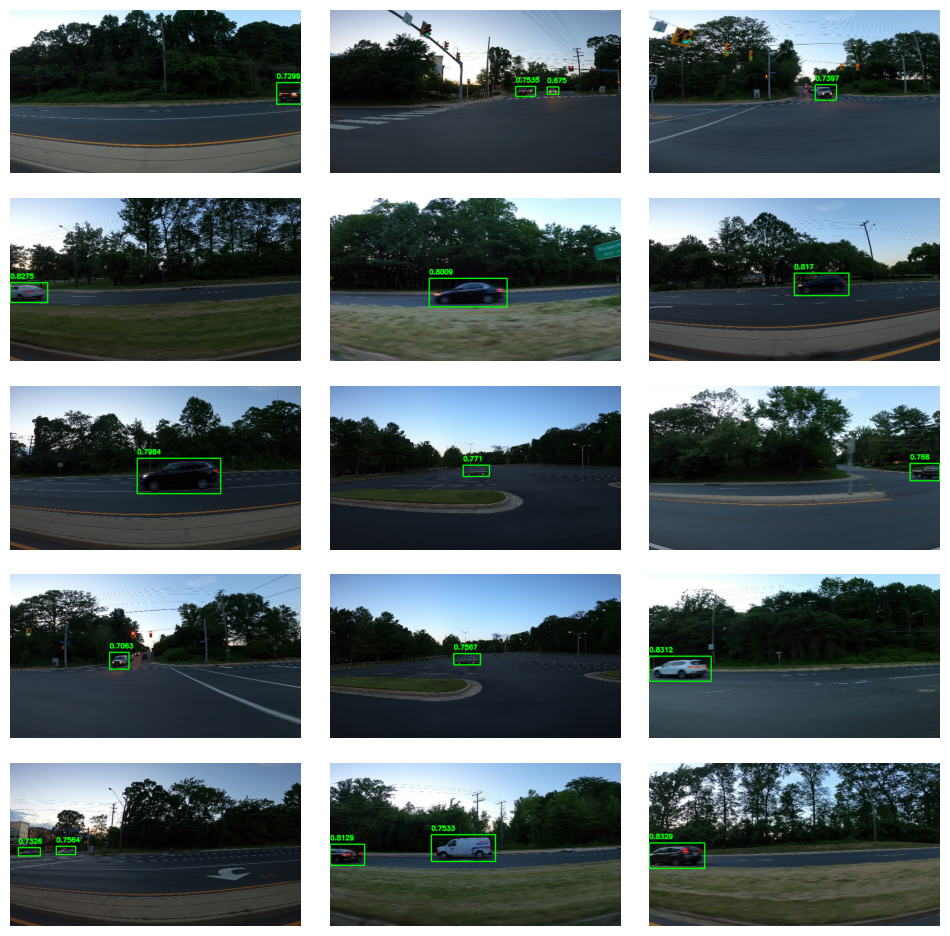

In [130]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_images_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(predictions_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    